## LOAD DATA

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
import re, string , unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
import nltk
# nltk.download()

In [3]:
df = pd.read_json('newsHeadlines/Sarcasm_Headlines_Dataset.json', lines = True, orient = 'columns')
df_v2 = pd.read_json('newsHeadlines/Sarcasm_Headlines_Dataset_v2.json', lines = True, orient = 'columns')
df = pd.concat([df, df_v2])
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
print(df.isna().sum())
print('')
df.drop(columns= ['article_link'], inplace= True)
df.info()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


## DATA CLEANING and PREPROCESSING


In [5]:
# convert to lowercase
df['headline'] = df['headline'].apply(lambda x: x.lower())

# remove punctuation
df['headline'] = df['headline'].apply(lambda x: ' '.join(
    word.strip(string.punctuation) for word in x.split()))

# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
headline = []
for sentence in df['headline']:
    filtered_list = []
    for word in sentence.split():
        if word not in stopwords:
            filtered_list.append(word)
    join_string = ' '.join([str(i) for i in filtered_list])
    headline.append(join_string)
df['headline'] = headline

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.2)

train_sentences = list(train_data['headline'])
train_labels = list(train_data['is_sarcastic'])

test_sentences = list(test_data['headline'])
test_labels = list(test_data['is_sarcastic'])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

C:\Users\apein\Anaconda3\envs\DL_tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


25.0

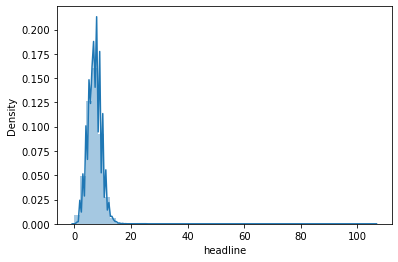

In [7]:
import seaborn as sns
headline_lengths = df['headline'].apply(lambda x: len(x.split())) 
sns.distplot(headline_lengths)
headline_lengths.quantile(0.9999)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 100
# as noted from above plot and data we see that 99.99% of headlines are of length 25 or less
# hence it is safe to assume that the suitable max length of a headline is 31
max_length = 32

oov_tok = '<OOV>'
trunc_type = 'post'


tokenizer = Tokenizer(oov_token= oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_idx = tokenizer.word_index
vocab_size = len(word_idx)

training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen= max_length, padding= 'post', truncating= trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen= max_length, padding= 'post', truncating= trunc_type)

In [9]:
print(training_sequences[0])
print(training_padded[0])

[2552, 287, 14266, 3258, 2, 3134, 67, 1170, 22385]
[ 2552   287 14266  3258     2  3134    67  1170 22385     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [10]:
training_padded = np.array(training_padded)
print(training_padded.shape)

testing_padded = np.array(testing_padded)
print(testing_padded.shape)

(44262, 32)
(11066, 32)


## MODEL

### with dropout

In [11]:
model1d = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length= max_length),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model1d.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2693000   
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [12]:
history = model1d.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model1d.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print(accuracy_score(y_true = test_labels, y_pred = res))
print(recall_score(y_true = test_labels, y_pred = res))
print(precision_score(y_true = test_labels, y_pred = res))
print(f1_score(y_true = test_labels, y_pred = res))

Epoch 1/10
1107/1107 [==============================] - 72s 59ms/step - loss: 1.1167 - accuracy: 0.7725 - val_loss: 0.4637 - val_accuracy: 0.8626
Epoch 2/10
1107/1107 [==============================] - 59s 54ms/step - loss: 0.3616 - accuracy: 0.9210 - val_loss: 0.3997 - val_accuracy: 0.8946
Epoch 3/10
1107/1107 [==============================] - 59s 53ms/step - loss: 0.2669 - accuracy: 0.9607 - val_loss: 0.3937 - val_accuracy: 0.9047
Epoch 4/10
1107/1107 [==============================] - 65s 59ms/step - loss: 0.2246 - accuracy: 0.9769 - val_loss: 0.4086 - val_accuracy: 0.9096
Epoch 5/10
1107/1107 [==============================] - 62s 56ms/step - loss: 0.2050 - accuracy: 0.9840 - val_loss: 0.4217 - val_accuracy: 0.9097
Epoch 6/10
1107/1107 [==============================] - 62s 56ms/step - loss: 0.1913 - accuracy: 0.9879 - val_loss: 0.4312 - val_accuracy: 0.9102
Epoch 7/10
1107/1107 [==============================] - 71s 64ms/step - loss: 0.1836 - accuracy: 0.9905 - val_loss: 0.4537 -

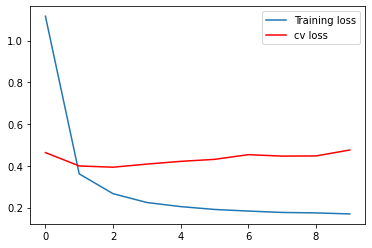

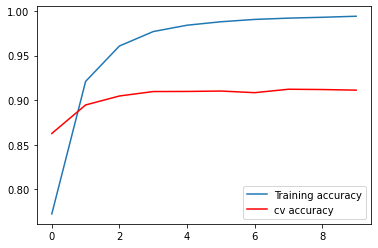

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()

### without dropout

In [14]:
model1 = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length= max_length),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model1.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model1.summary()

history = model1.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model1.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print(accuracy_score(y_true = test_labels, y_pred = res))
print(recall_score(y_true = test_labels, y_pred = res))
print(precision_score(y_true = test_labels, y_pred = res))
print(f1_score(y_true = test_labels, y_pred = res))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           2693000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 128)           12928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,817,745
Trainable params: 2,817,745
Non-trainable params: 0
____________________________________________

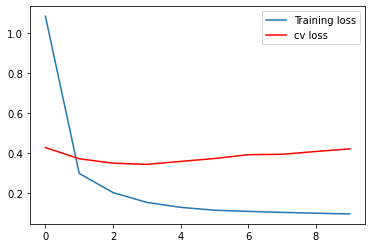

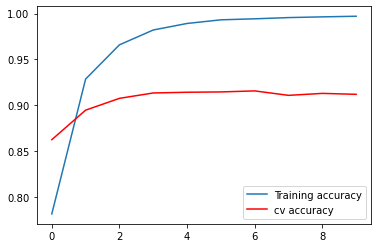

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()

## models with GLOVE embeddings layer as i/p

In [16]:
embeddings_idx = {}
with open('glove.6B.100d.txt', encoding= 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype= 'float32')
        embeddings_idx[word] = coefs
        
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for key in sorted(word_idx, key= word_idx.get)[:vocab_size]:
    embedding_vec = embeddings_idx.get(key)
    if embedding_vec is not None:
        embedding_matrix[word_idx[key]] = embedding_vec


In [17]:
embedding_matrix.shape

(26930, 100)

In [18]:
for key in sorted(word_idx, key=word_idx.get)[:10]:
  print(key,end=' ')
  print(word_idx.get(key))

<OOV> 1
new 2
trump 3
man 4
report 5
one 6
year 7
day 8
area 9
u 10


In [19]:
for key in sorted(word_idx, key=word_idx.get)[:10]:
  print(key,end=' ')
  print(embeddings_idx.get(key))

<OOV> None
new [-4.3959e-02  1.8936e-01  6.6110e-01 -4.9007e-01  3.2211e-01 -3.4161e-01
 -6.8480e-02  3.1364e-01 -7.1142e-01  5.7436e-01 -3.3588e-01 -5.2279e-01
 -3.9075e-01 -8.9694e-02  4.6371e-01 -3.5610e-01  8.4576e-01 -2.6188e-02
 -1.9328e-01 -8.3846e-02  3.1806e-01 -1.9812e-01  3.0009e-01  6.9189e-02
  5.4470e-01 -5.9193e-01  5.4221e-01 -6.2876e-01 -5.3447e-01  4.2334e-01
  3.0869e-02  9.7164e-01 -5.6222e-01  4.5752e-02 -5.7100e-01  8.0185e-02
 -8.1434e-02 -6.0260e-01  1.6466e-01 -4.0281e-01 -4.7701e-01 -5.1950e-01
  1.2777e-01 -4.3775e-01  2.6602e-01  4.8752e-01 -6.0220e-02 -5.2622e-01
  3.7687e-01 -1.8007e-01  3.0166e-02 -9.4577e-02  1.6330e-01  5.9041e-01
 -4.8877e-01 -3.4230e+00  1.3113e-01 -8.0386e-02  1.8978e+00  1.8857e-01
 -5.7300e-01  8.6358e-01  2.1116e-03  3.6060e-01  8.0475e-01 -1.3954e-01
 -5.3935e-02  3.8873e-01  3.0673e-01 -3.1395e-01  8.3238e-02 -4.1737e-01
 -1.0998e+00 -8.8005e-01  2.1550e-01 -2.6132e-01 -1.0091e-01  7.9584e-02
 -1.2341e+00 -6.5281e-01  6.3363e-01

### with dropout

In [20]:
vocab_size = len(word_idx)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2d = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embedding_dim, input_length= max_length, weights= [embedding_matrix]),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model2d.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model2d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2693000   
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [21]:
history = model2d.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model2d.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print(accuracy_score(y_true = test_labels, y_pred = res))
print(recall_score(y_true = test_labels, y_pred = res))
print(precision_score(y_true = test_labels, y_pred = res))
print(f1_score(y_true = test_labels, y_pred = res))

Epoch 1/10
1107/1107 [==============================] - 78s 65ms/step - loss: 1.1241 - accuracy: 0.7779 - val_loss: 0.4659 - val_accuracy: 0.8630
Epoch 2/10
1107/1107 [==============================] - 70s 64ms/step - loss: 0.3823 - accuracy: 0.9113 - val_loss: 0.4023 - val_accuracy: 0.8861
Epoch 3/10
1107/1107 [==============================] - 77s 69ms/step - loss: 0.2773 - accuracy: 0.9570 - val_loss: 0.3699 - val_accuracy: 0.9143
Epoch 4/10
1107/1107 [==============================] - 80s 72ms/step - loss: 0.2320 - accuracy: 0.9740 - val_loss: 0.3749 - val_accuracy: 0.9199
Epoch 5/10
1107/1107 [==============================] - 68s 61ms/step - loss: 0.2021 - accuracy: 0.9847 - val_loss: 0.3856 - val_accuracy: 0.9206
Epoch 6/10
1107/1107 [==============================] - 70s 63ms/step - loss: 0.1892 - accuracy: 0.9888 - val_loss: 0.3933 - val_accuracy: 0.9210
Epoch 7/10
1107/1107 [==============================] - 71s 64ms/step - loss: 0.1841 - accuracy: 0.9909 - val_loss: 0.4041 -

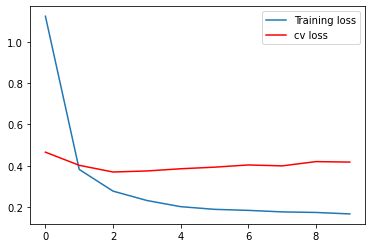

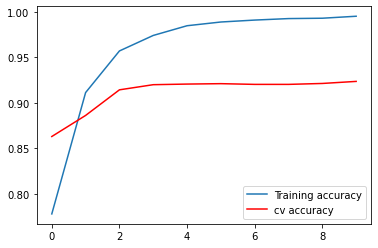

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()

### without dropout

In [23]:
vocab_size = len(word_idx)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2 = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embedding_dim, input_length= max_length, weights= [embedding_matrix]),
    keras.layers.Conv1D(128, 1, activation= 'relu'),
    keras.layers.MaxPooling1D(2, padding= 'same'),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.01), activation= 'relu'),
    keras.layers.Dense(1, kernel_regularizer = keras.regularizers.l1(0.01), activation= 'sigmoid')
])

model2.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           2693000   
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,817,745
Trainable params: 2,817,745
Non-trainable params: 0
______________________________________________

In [24]:
history = model2.fit(training_padded, train_labels, epochs= 10, validation_split= 0.2)
res = (model2.predict(testing_padded) > 0.5).astype(int).reshape(-1)
print(accuracy_score(y_true = test_labels, y_pred = res))
print(recall_score(y_true = test_labels, y_pred = res))
print(precision_score(y_true = test_labels, y_pred = res))
print(f1_score(y_true = test_labels, y_pred = res))

Epoch 1/10
1107/1107 [==============================] - 84s 68ms/step - loss: 1.0878 - accuracy: 0.7895 - val_loss: 0.4314 - val_accuracy: 0.8632
Epoch 2/10
1107/1107 [==============================] - 78s 71ms/step - loss: 0.3212 - accuracy: 0.9204 - val_loss: 0.3634 - val_accuracy: 0.8972
Epoch 3/10
1107/1107 [==============================] - 80s 72ms/step - loss: 0.2093 - accuracy: 0.9654 - val_loss: 0.3217 - val_accuracy: 0.9179
Epoch 4/10
1107/1107 [==============================] - 79s 71ms/step - loss: 0.1576 - accuracy: 0.9819 - val_loss: 0.3267 - val_accuracy: 0.9244
Epoch 5/10
1107/1107 [==============================] - 81s 73ms/step - loss: 0.1312 - accuracy: 0.9891 - val_loss: 0.3525 - val_accuracy: 0.9227
Epoch 6/10
1107/1107 [==============================] - 79s 72ms/step - loss: 0.1183 - accuracy: 0.9927 - val_loss: 0.3600 - val_accuracy: 0.9224
Epoch 7/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.1109 - accuracy: 0.9944 - val_loss: 0.3668 -

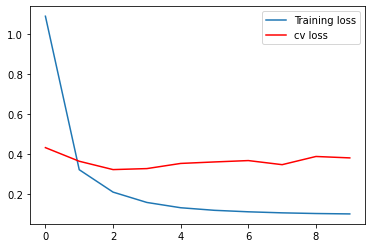

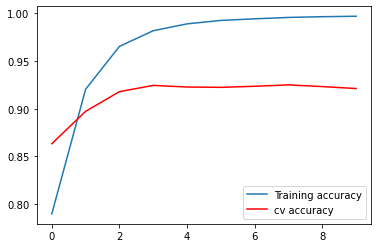

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='cv loss')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='cv accuracy')
plt.legend()

## FINDINGS

#### methodology
* We implement 4 types of models with various combinations of Dropout and different word embeddings as input
* We assume all sentences to be of length = 32, as 99.99%ile of sentences are  <= 25 in length 
* Base design :
  * We have a embeddings layer -> passed to Conv1D -> maxpool -> Bidirectional LSTM -> Dense Layers -> output
* Model category 1:-
  * Using simple embeddings layers as input
  * Model category 1a :-
    * Uses Dropout regularization + Base Design
  * Model category 1b :-
    * No dropout regularization + Base design
* Model category 2 :
  * Uses 100 length GloVE embeddings as embeddings layer
  * Model category 2a :- 
    * Dropout regularization + GloVE embeddings layer + Base design
  * Model category 2b :-
    * no dropout + GloVE embeddings layer + Base design
  
#### observations
* Dropout regularization either keeps performance almost identical or leads to a decrease in performance for both types of models considered
  * hence dropuout is not beneficial to this model design
* GloVE embeddings in embeddings layer do not increase performance(accuracy) as compared to normal embeddings layer as input 
  
### note:
* we simply predict '1' if the predicted probability of a model is > 0.5 and false otherwise. Tweaking the '0.5' could lead to different performance measures

### EXPERIMENTS & CONCLUSIONS: 
* To increase size of dataset, we append the datasets Sarcasm_detection and Saracasm_detection_v2. This gives a corpus of 55,528 news headlines.
  * To evaluate model performance, we first create a test set, that we keep alien from the training set. We then evaluate the model on the test set.
    * Size of test set = 11,066 (20% of 55,328)
    * Size of training set = 44,262 (80% of 55,328)
  * We then train the model on the training set with a cross validation split of 0.2
  * Finally we evaluate the performance of the model on the test set, using accuracy as a metric.

* We do not remove stopwords (conjunctions, connectors etc.) as we feel they are important in the context of sarcasm detection.

#### Model specific information:

##### LSTM model:
* Apart from running simple LSTM models, we also check performances with addition of dropout regularization
* **Experiment conditions:**
    * Number of epochs = 30
    * Batch size = 256
    * Optimizer = Adam
    * Learning rate = 0.01
    * Loss function = binary cross entropy
* We note that dropout regularization, reduces the problem of overfitting, and provides better performance on both the validation and test data.
* _Without dropout :_ 
  * Train Accuracy = 99.85%
  * Validation accuracy = 92.251%
  * Test accuracy = 94.26%
* _With dropout :_
    * Train accuracy = 99.81%
    * Validation accuracy = 94.33%
    * Test accuracy = 95.12%
    * Test recall = 94.87%
    * Test precision = 94.72%
    * Test f1 score = 94.79%

##### BERT model :
* Experiment conditions : 
  * Number of epochs = 3
  * Batch size = 32
  * Optimizer = Adam
  * Learning rate = 1e-5
  * Loss function = binary cross entropy
* Through trial and error we notice that the performance of the BERT model is best assuming a sentence length of 20 words.

* We noted that the performance of the model shot up (test accuracy : 92.34% inc. to 97.54%) on increasing data (data was increased by appending Sarcasm_detection_v2 dataset to the original Sarcasm_detection.json dataset)

* **Observations :-**
  * train accuracy = 98.47%
  * validation accuracy = 97.31%

* We also see that predicting true for higher predicted probabilities yields better results : 
  * _predicting true for predicted probability >= 0.7:_ 
    *   test accuracy = 97.734%
    *   recall = 97.91%
    *   precision = 97.20%
    *   f1_score = 97.55%
  
  * _predicting true for predicted probability >= 0.5:_
    * test accuracy = 97.542%
    * recall = 98.30%
    * precision = 96.44%
    * f1_score = 97.36%
  
  * _predicting true for predicted probability >= 0.3:_ 
    * test accuracy = 96.952%
    * recall = 98.67%
    * precision = 94.93%
    * f1_score = 96.76%
  
* **These observations lead us to conclude that model performance(wrt test accuracy) is better with increase in the precision. That is, the dataset seems to place a higher importance on minimizing the number of false positives**.


##### CNN + BiLSTM model : 
* We assume a length of **32 words** for each sentence. 
  * _Reason for this assumption_ :
    * during EDA(exploratory data analysis), we found that 99.99% of the sentences are <= 25 words in length. Henceassuming that the max length fo a sentence could be ~ 3 words before or after the likely sentence length, we can assume that the length of a sentence could be 32 words.

* _Embeddings we use :_ 
  * Simple embeddings layer
  * Glove 100d embeddings vectors

* _Regularization techniques used :_
  * Dropout regularization
  * L2 regularization

* On evaluating the performance of all the combinations we note the following :
    * **Experiment conditions:** 
        Number of epochs = 10
        Batch size = 32
        Optimizer = Adam
        Learning rate = 0.01
        Loss function = binary cross entropy

      * _Using dropout regularization and simple embeddings layer_ : 
        * Train accuracy = 99.40%
        * Cross validation accuracy = 91.12%
        * Test accuracy = 90.76%
        * Test recall = 89.94%
        * Test precision = 89.87%
        * Test f1 score = 89.91%
  
      * _Using no dropout regularization and simple embeddings layer :_
        * Train accuracy = 99.71%
        * Cross validation accuracy = 91.20%
        * Test accuracy = 90.81%
        * Test recall = 90.86%
        * Test precision = 89.25%
        * Test f1 score = 90.04%
  
      * _Using dropout regularization and GloVe 100d embeddings layer :_
        * Train accuracy = 99.51%
        * Cross validation accuracy = 92.35%
        * Test accuracy = 91.53%
        * Test recall = 88.30%
        * Test precision = 92.84%
        * Test f1 score = 90.52%
  
      * _Using no dropout regularization and GloVe 100d embeddings layer :_
        * Train accuracy = 99.71%
        * Cross validation accuracy = 92.12%
        * Test accuracy = 91.65%
        * Test recall = 91.84%
        * Test precision = 90.10%
        * Test f1 score = 90.96%
    

* **From these observations we see that dropout regularization either keeps performance almost identical or leads to a decrease in performance for both types of models considered**. Hence we may arrive at either of the following conclusions:
    1. Dropout regularization is not beneficial to this type of model design.
    2. We may be running the model for far too few iterations (due to computing restrictions) and thus are not able to witness the effect of dropout regularization.

* **Moreover, the use of GloVe embeddings improves the performance of the model** (both the models with GloVe embeddings layer as input performed better than models with simple embeddings layer as input).

    

    